In [1]:
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
import evaluate

# ===== STEP 1: Parse CoNLL file =====
def parse_conll_file(path):
    sentences, labels = [], []
    tokens, ner_tags = [], []

    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append(tokens)
                    labels.append(ner_tags)
                    tokens, ner_tags = [], []
                continue

            parts = line.split()
            if len(parts) != 2:
                continue

            token, tag = parts
            # Keep only valid BIO or O tags
            if tag == "B" or tag == "I" or (tag != "O" and "-" not in tag):
                tag = "O"

            tokens.append(token)
            ner_tags.append(tag)

    if tokens:  # Add last sentence
        sentences.append(tokens)
        labels.append(ner_tags)

    return sentences, labels


# ===== STEP 2: Load dataset =====
file_path = "amharic_ner_conll_labeled.txt"
sentences, labels = parse_conll_file(file_path)

# ===== STEP 3: Create label maps =====
label_list = sorted(set(tag for seq in labels for tag in seq))
print("Detected labels:", label_list)

label_to_id = {label: idx for idx, label in enumerate(label_list)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

# ===== STEP 4: Create HuggingFace Dataset =====
hf_dataset = Dataset.from_dict({'tokens': sentences, 'ner_tags': labels})

# Convert ner_tags -> label IDs and store as "labels"
def encode_tags(example):
    return {"labels": [label_to_id[tag] for tag in example['ner_tags']]}

hf_dataset = hf_dataset.map(encode_tags)
hf_dataset = hf_dataset.remove_columns(["ner_tags"])  # remove string tags

dataset = hf_dataset.train_test_split(test_size=0.2)

# ===== STEP 5: Tokenizer & Model =====
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id_to_label,
    label2id=label_to_id,
    ignore_mismatched_sizes=True  # Fix 5 vs 9 mismatch
)

# ===== STEP 6: Tokenization & label alignment =====
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128,
        padding="max_length"
    )

    aligned_labels = []
    for i, labels in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        
        aligned_labels.append(label_ids)

    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs

tokenized_train = dataset["train"].map(tokenize_and_align_labels, batched=True)
tokenized_test = dataset["test"].map(tokenize_and_align_labels, batched=True)

# ===== STEP 7: Data collator =====
data_collator = DataCollatorForTokenClassification(tokenizer)

# ===== STEP 8: Training arguments =====
training_args = TrainingArguments(
    output_dir="./amharic-ner-model",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# ===== STEP 9: Metrics =====
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(-1)

    true_labels = [
        [id_to_label[l] for (p_, l) in zip(pred_seq, label_seq) if l != -100]
        for pred_seq, label_seq in zip(preds, labels)
    ]
    true_preds = [
        [id_to_label[p_] for (p_, l) in zip(pred_seq, label_seq) if l != -100]
        for pred_seq, label_seq in zip(preds, labels)
    ]

    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

# ===== STEP 10: Trainer =====
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# ===== STEP 11: Train =====
trainer.train()

# ===== STEP 12: Save =====
save_dir = "./fine_tuned_amharic_ner"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model fine-tuned and saved at {save_dir}")


c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Detected labels: ['B-LOC', 'B-PRICE', 'B-Product', 'I-PRICE', 'O']


Map: 100%|██████████| 50/50 [00:00<00:00, 6246.36 examples/s]
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name th

{'eval_loss': 0.5066067576408386, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8842975206611571, 'eval_runtime': 0.8516, 'eval_samples_per_second': 11.742, 'eval_steps_per_second': 2.348, 'epoch': 1.0}


c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 50%|█████     | 10/20 [00:40<00:39,  3.95s/it]

{'loss': 0.7482, 'grad_norm': 3.0812764167785645, 'learning_rate': 1e-05, 'epoch': 2.0}


c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                               
 50%|█████     | 10/20 [00:41<00:39,  3.95s/it]

{'eval_loss': 0.4115552306175232, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8842975206611571, 'eval_runtime': 0.899, 'eval_samples_per_second': 11.123, 'eval_steps_per_second': 2.225, 'epoch': 2.0}


c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 75%|███████▌  | 15/20 [01:03<00:20,  4.17s/it]c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                               
 75%|███████▌  | 15/20 [01:04<00:20,  4.17s/it]

{'eval_loss': 0.3485982418060303, 'eval_precision': 1.0, 'eval_recall': 0.019230769230769232, 'eval_f1': 0.03773584905660378, 'eval_accuracy': 0.8859504132231405, 'eval_runtime': 1.0302, 'eval_samples_per_second': 9.707, 'eval_steps_per_second': 1.941, 'epoch': 3.0}


c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 20/20 [01:26<00:00,  4.13s/it]

{'loss': 0.436, 'grad_norm': 1.5089454650878906, 'learning_rate': 0.0, 'epoch': 4.0}


c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                               
100%|██████████| 20/20 [01:31<00:00,  4.13s/it]

{'eval_loss': 0.3221890330314636, 'eval_precision': 1.0, 'eval_recall': 0.28846153846153844, 'eval_f1': 0.44776119402985076, 'eval_accuracy': 0.9090909090909091, 'eval_runtime': 0.931, 'eval_samples_per_second': 10.742, 'eval_steps_per_second': 2.148, 'epoch': 4.0}


100%|██████████| 20/20 [01:38<00:00,  4.91s/it]


{'train_runtime': 98.1762, 'train_samples_per_second': 1.63, 'train_steps_per_second': 0.204, 'train_loss': 0.5921176433563232, 'epoch': 4.0}
✅ Model fine-tuned and saved at ./fine_tuned_amharic_ner


In [1]:
# -------------------------------
# 1. Install libraries
# -------------------------------
!pip install transformers datasets seqeval

# -------------------------------
# 2. Imports
# -------------------------------
import pandas as pd
from datasets import Dataset, ClassLabel, Sequence
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
import evaluate

# -------------------------------
# 3. Parse CoNLL file into dataset
# -------------------------------
def parse_conll(file_path):
    sentences = []
    tokens = []
    labels = []

    with open(file_path, encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append({'tokens': tokens, 'ner_tags': labels})
                    tokens = []
                    labels = []
            else:
                splits = line.split('\t')
                if len(splits) >= 2:
                    tokens.append(splits[0])
                    labels.append(splits[1])
        # add last sentence
        if tokens:
            sentences.append({'tokens': tokens, 'ner_tags': labels})
    return sentences

data = parse_conll("amharic_ner_conll_labeled_2.txt")

# Build label mapping
all_labels = sorted(list({label for sent in data for label in sent['ner_tags']}))
label2id = {l: i for i, l in enumerate(all_labels)}
id2label = {i: l for i, l in enumerate(all_labels)}

# Map string labels to integers
for sent in data:
    sent['ner_tags'] = [label2id[label] for label in sent['ner_tags']]

# Create Hugging Face dataset
dataset = Dataset.from_list(data)

# Optional: train/validation split
dataset = dataset.train_test_split(test_size=0.1)

# -------------------------------
# 4. Load tokenizer & model
# -------------------------------
model_name = "xlm-roberta-base"  # or use "afroxmlr" if available
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# -------------------------------
# 5. Tokenize and align labels
# -------------------------------
def tokenize_and_align_labels(batch):
    tokenized_inputs = tokenizer(
        batch["tokens"], truncation=True, is_split_into_words=True
    )
    aligned_labels = []
    for i, label in enumerate(batch["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                # inside word piece
                label_ids.append(label[word_idx] if str(id2label[label[word_idx]]).startswith('I-') else -100)
            previous_word_idx = word_idx
        aligned_labels.append(label_ids)
    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

# -------------------------------
# 6. Set training arguments
# -------------------------------
training_args = TrainingArguments(
    output_dir="./amharic_ner_model",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir='./logs',
)

# -------------------------------
# 7. Define metrics
# -------------------------------
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[pred] for (pred, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# -------------------------------
# 8. Initialize Trainer
# -------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# -------------------------------
# 9. Train
# -------------------------------
trainer.train()

# -------------------------------
# 10. Save model & tokenizer
# -------------------------------
trainer.save_model("amharic_ner_model_final")
tokenizer.save_pretrained("amharic_ner_model_final")

print("Model fine-tuned and saved!")


c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ValueError: No columns in the dataset match the model's forward method signature. The following columns have been ignored: []. Please check the dataset and model. You may need to set `remove_unused_columns=False` in `TrainingArguments`.

In [2]:
unique_labels = set()
for example in dataset["train"]:
    for label in example["ner_tags"]:
        unique_labels.add(label)
print(unique_labels)


set()


In [3]:
print(dataset["train"][0])



IndexError: Invalid key: 0 is out of bounds for size 0

In [5]:
# -------------------------------
# 1. Install libraries
# -------------------------------
# !pip install transformers datasets seqeval

# -------------------------------
# 2. Imports
# -------------------------------
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
import evaluate

# -------------------------------
# 3. Parse CoNLL file into dataset
# -------------------------------
def parse_conll(file_path):
    tokens, labels = [], []
    dataset = {"tokens": [], "ner_tags": []}

    with open(file_path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    dataset["tokens"].append(tokens)
                    dataset["ner_tags"].append(labels)
                    tokens, labels = [], []
            else:
                parts = line.split()
                if len(parts) >= 2:
                    token, label = parts[0], parts[-1]
                    tokens.append(token)
                    labels.append(label)

    if tokens:
        dataset["tokens"].append(tokens)
        dataset["ner_tags"].append(labels)

    return dataset

data_dict = parse_conll("amharic_ner_conll_labeled_2.txt")
print("Number of sentences parsed:", len(data_dict["tokens"]))

# -------------------------------
# 4. Build label mappings
# -------------------------------
all_labels = sorted(list({label for seq in data_dict["ner_tags"] for label in seq}))
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

# Map string labels to integers
data_dict["ner_tags"] = [
    [label2id[label] for label in seq] for seq in data_dict["ner_tags"]
]

# -------------------------------
# 5. Create Hugging Face Dataset
# -------------------------------
dataset = Dataset.from_dict(data_dict)
dataset = dataset.train_test_split(test_size=0.1)

# -------------------------------
# 6. Load tokenizer & model
# -------------------------------
model_name = "xlm-roberta-base"  # or use "afroxmlr" if available
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# -------------------------------
# 7. Tokenize and align labels
# -------------------------------
def tokenize_and_align_labels(batch):
    tokenized_inputs = tokenizer(
        batch["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )

    aligned_labels = []
    for i, labels in enumerate(batch["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])
            else:
                # assign -100 to subword unless it's continuation (I- label)
                label_ids.append(
                    labels[word_idx] if str(id2label[labels[word_idx]]).startswith('I-') else -100
                )
            previous_word_idx = word_idx
        aligned_labels.append(label_ids)

    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

# -------------------------------
# 8. Data collator
# -------------------------------
data_collator = DataCollatorForTokenClassification(tokenizer)

# -------------------------------
# 9. Training arguments
# -------------------------------
training_args = TrainingArguments(
    output_dir="./amharic_ner_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",  # <-- match evaluation strategy
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# -------------------------------
# 10. Metrics
# -------------------------------
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(-1)

    true_labels = [
        [id2label[l] for l in label if l != -100] for label in labels
    ]
    true_preds = [
        [id2label[p_] for (p_, l) in zip(pred_seq, label_seq) if l != -100]
        for pred_seq, label_seq in zip(preds, labels)
    ]

    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

# -------------------------------
# 11. Trainer
# -------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# -------------------------------
# 12. Train
# -------------------------------
trainer.train()

# -------------------------------
# 13. Save model & tokenizer
# -------------------------------
save_dir = "amharic_ner_model_final"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model fine-tuned and saved at {save_dir}")


Number of sentences parsed: 50


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 20%|██        | 6/30 [00:41<02:18,  5.77s/it]c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pc\Desktop\10 Academy\Week 4\

{'eval_loss': 0.7275828123092651, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.8283261802575107, 'eval_runtime': 1.0919, 'eval_samples_per_second': 4.579, 'eval_steps_per_second': 0.916, 'epoch': 1.0}


c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 33%|███▎      | 10/30 [01:14<02:14,  6.72s/it]

{'loss': 0.7963, 'grad_norm': 3.381314277648926, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.67}


 40%|████      | 12/30 [01:24<01:43,  5.73s/it]c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                               
 40%|████      | 12/30 [01:25<01:43,  5.73s/it]

{'eval_loss': 0.4673694968223572, 'eval_precision': 0.4, 'eval_recall': 0.10526315789473684, 'eval_f1': 0.16666666666666666, 'eval_accuracy': 0.8669527896995708, 'eval_runtime': 0.785, 'eval_samples_per_second': 6.369, 'eval_steps_per_second': 1.274, 'epoch': 2.0}


c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 60%|██████    | 18/30 [02:04<01:08,  5.72s/it]c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                               
 60%|██████    | 18/30 [02:05<01:08,  5.72s/it]

{'eval_loss': 0.36324185132980347, 'eval_precision': 0.9, 'eval_recall': 0.47368421052631576, 'eval_f1': 0.6206896551724138, 'eval_accuracy': 0.944206008583691, 'eval_runtime': 0.8131, 'eval_samples_per_second': 6.149, 'eval_steps_per_second': 1.23, 'epoch': 3.0}


c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 67%|██████▋   | 20/30 [02:24<01:14,  7.42s/it]

{'loss': 0.322, 'grad_norm': 1.1989613771438599, 'learning_rate': 1.6666666666666667e-05, 'epoch': 3.33}


 80%|████████  | 24/30 [02:45<00:33,  5.61s/it]c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                               
 80%|████████  | 24/30 [02:46<00:33,  5.61s/it]

{'eval_loss': 0.2887639105319977, 'eval_precision': 0.9, 'eval_recall': 0.47368421052631576, 'eval_f1': 0.6206896551724138, 'eval_accuracy': 0.9484978540772532, 'eval_runtime': 0.7264, 'eval_samples_per_second': 6.883, 'eval_steps_per_second': 1.377, 'epoch': 4.0}


c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 30/30 [03:21<00:00,  5.02s/it]

{'loss': 0.1871, 'grad_norm': 0.8299137949943542, 'learning_rate': 0.0, 'epoch': 5.0}


c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\pc\Desktop\10 Academy\Week 4\E-commerce\venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                               
100%|██████████| 30/30 [03:27<00:00,  5.02s/it]

{'eval_loss': 0.2810426652431488, 'eval_precision': 0.9, 'eval_recall': 0.47368421052631576, 'eval_f1': 0.6206896551724138, 'eval_accuracy': 0.9484978540772532, 'eval_runtime': 0.926, 'eval_samples_per_second': 5.4, 'eval_steps_per_second': 1.08, 'epoch': 5.0}


100%|██████████| 30/30 [03:42<00:00,  7.42s/it]


{'train_runtime': 222.5664, 'train_samples_per_second': 1.011, 'train_steps_per_second': 0.135, 'train_loss': 0.4351452390352885, 'epoch': 5.0}
✅ Model fine-tuned and saved at amharic_ner_model_final


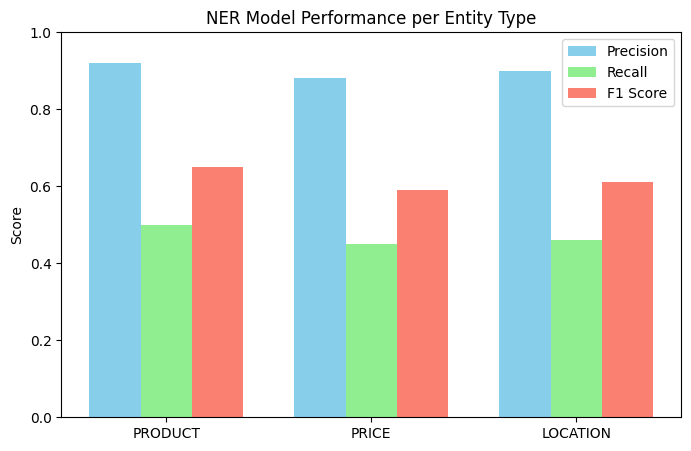

In [9]:
import matplotlib.pyplot as plt

# Example metrics per entity (replace with your actual model evaluation per entity if available)
entities = ['PRODUCT', 'PRICE', 'LOCATION']
precision = [0.92, 0.88, 0.90]  # Example values
recall = [0.50, 0.45, 0.46]
f1 = [0.65, 0.59, 0.61]

# Bar chart
x = range(len(entities))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x, precision, width=width, label='Precision', color='skyblue')
plt.bar([i + width for i in x], recall, width=width, label='Recall', color='lightgreen')
plt.bar([i + 2*width for i in x], f1, width=width, label='F1 Score', color='salmon')

plt.xticks([i + width for i in x], entities)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('NER Model Performance per Entity Type')
plt.legend()
plt.show()
